In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools
from matplotlib.pylab import rcParams
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Load the Data/Filtering for Chosen Zipcodes and Data Preprocessing

In [2]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


I decided to take a look at the best place to invest in the city of Los Angeles so I'll make a new dataframe only containing data from Los Angeles.

In [3]:
los_angeles = df[df['City'] == 'Los Angeles']

In [4]:
los_angeles.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
30,96027,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,31,340600.0,341700.0,343000.0,...,1839800,1861100,1888600,1903900,1907500,1922100,1952400,1974500,1975900,1966900
75,96015,90034,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,76,231300.0,231700.0,232100.0,...,1287500,1310000,1329900,1347200,1360300,1368500,1382700,1398000,1411400,1419100
86,96025,90044,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,87,119500.0,119500.0,119400.0,...,383800,386900,390600,394300,398600,404200,409700,414300,418500,421100
107,96007,90026,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,108,138100.0,138300.0,138300.0,...,883600,895800,907700,919900,932600,947300,962600,973700,975200,972100
133,96047,90066,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,134,241100.0,241000.0,240900.0,...,1435000,1454100,1471100,1473300,1470400,1476200,1490500,1496300,1494000,1489900


In [5]:
## check to see how many unique zipcodes there are

los_angeles['RegionName'].nunique()

95

In [6]:
## changing dataframe to long format so it is easier to work with for time series modeling

LA = pd.melt(los_angeles, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='time')
LA['time'] = pd.to_datetime(LA['time'], infer_datetime_format=True)
LA = LA.dropna(subset=['value'])

In [7]:
LA['RegionName'].unique()

array([90046, 90034, 90044, 90026, 90066, 90019, 90004, 91342, 90011,
       90025, 90027, 91335, 90731, 90036, 91331, 90042, 90006, 90024,
       90028, 91402, 91367, 90049, 91406, 90020, 91405, 91601, 90047,
       90018, 90003, 91343, 90045, 90016, 90043, 91304, 90037, 90005,
       91344, 90057, 91605, 90029, 90291, 91606, 91423, 90065, 90292,
       90008, 91401, 91604, 90744, 91306, 90035, 91607, 90048, 91311,
       90007, 90068, 90032, 90012, 90033, 90038, 90064, 91326, 91316,
       90039, 90002, 91325, 91403, 90017, 91352, 91356, 90031, 90023,
       91364, 90041, 90059, 90015, 91042, 91602, 90272, 91324, 91303,
       90062, 91411, 90710, 90732, 91307, 91040, 90061, 90293, 91436,
       91345, 90077, 90248, 90013, 90014], dtype=int64)

In [8]:
## getting rid of unnecessary columns

LA = LA.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)
LA.head()

,RegionName,time,value
0,90046,1996-04-01,340600.0
1,90034,1996-04-01,231300.0
2,90044,1996-04-01,119500.0
3,90026,1996-04-01,138100.0
4,90066,1996-04-01,241100.0


In [9]:
## checking to see if there are any zipcodes with missing values

LA['RegionName'].value_counts()[-7:]

90049    265
90065    265
91303    265
91335    265
90732    265
90013     58
90014     58
Name: RegionName, dtype: int64

In [10]:
## removing zipcodes that have missing values

LA = LA[~LA['RegionName'].isin([90013, 90014])]

In [11]:
## checking to see if the zipcodes got removed properly

LA['RegionName'].value_counts()[-5:]

90065    265
91303    265
91335    265
91367    265
90732    265
Name: RegionName, dtype: int64

# EDA and Visualization

Now that we have our data, lets take a quick look at the values of homes in Los Angeles for each zipcode.

In [12]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


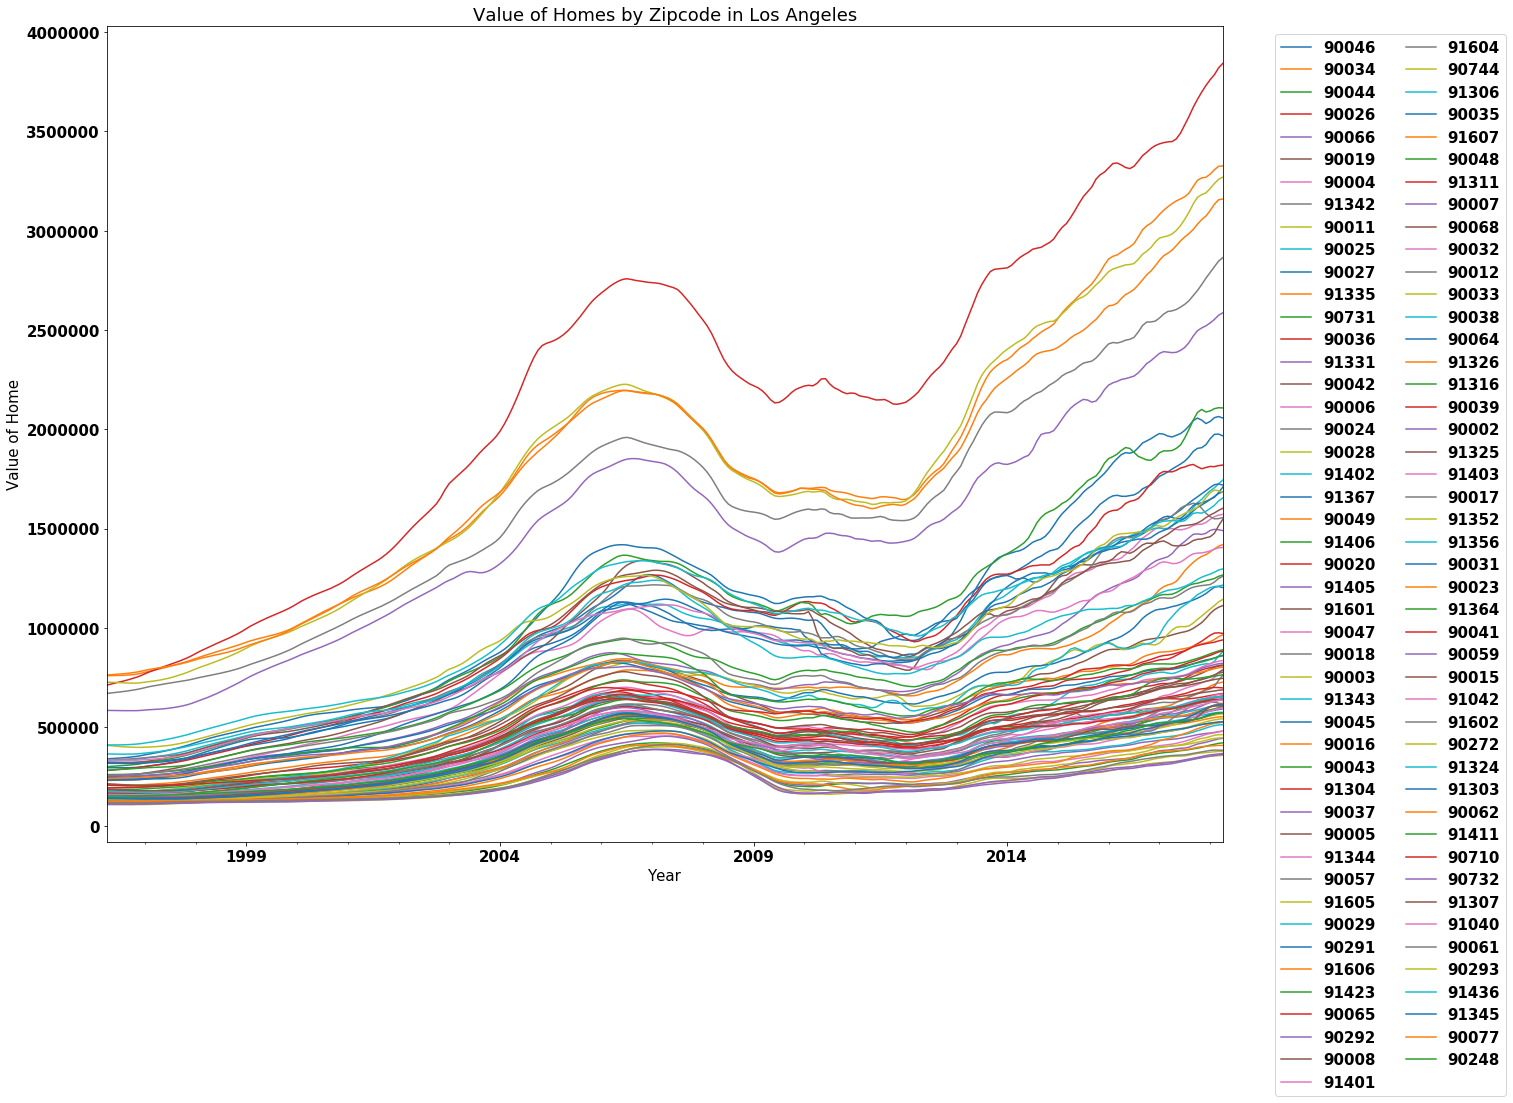

In [13]:
for zipcode in LA['RegionName'].unique():
    temp_df = LA[LA['RegionName'] == zipcode].drop('RegionName', axis=1).set_index('time')
    temp_df['value'].plot(figsize=(20, 15), label=zipcode)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.ylabel('Value of Home')
plt.xlabel('Year')
plt.title('Value of Homes by Zipcode in Los Angeles')
plt.show()

Taking a quick glance at the data, you can clearly see the effects of the housing crash in 2008 affecting housing prices throughout Los Angeles. It looks like the zipcodes with the highest home values were able to recover their losses by 2013-2014 and have reached new highs. However, the zipcodes with the lowest home values have yet to recover to their pre-2008 values. Since we are looking for the zipcodes with the highest return on investment, I'll be taking a look at the best zipcodes to invest in from the top 20 zipcodes in Los Angeles.

In [14]:
## making a new dataframe with just the values from the top 20 zipcodes in Los Angeles

top_20 = los_angeles.nlargest(20, '2018-04')
top_20 = top_20 = pd.melt(top_20, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='time')
top_20['time'] = pd.to_datetime(top_20['time'], infer_datetime_format=True)
top_20 = top_20.dropna(subset=['value'])
top_20 = top_20.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)
top_20.head()

,RegionName,time,value
0,90020,1996-04-01,711600.0
1,90049,1996-04-01,759100.0
2,90272,1996-04-01,726400.0
3,90077,1996-04-01,762500.0
4,90024,1996-04-01,669700.0


In [15]:
top_20['RegionName'].unique()

array([90020, 90049, 90272, 90077, 90024, 90292, 90048, 90291, 90046,
       90036, 90025, 90027, 90035, 90064, 90293, 91436, 90068, 90004,
       91604, 90005], dtype=int64)

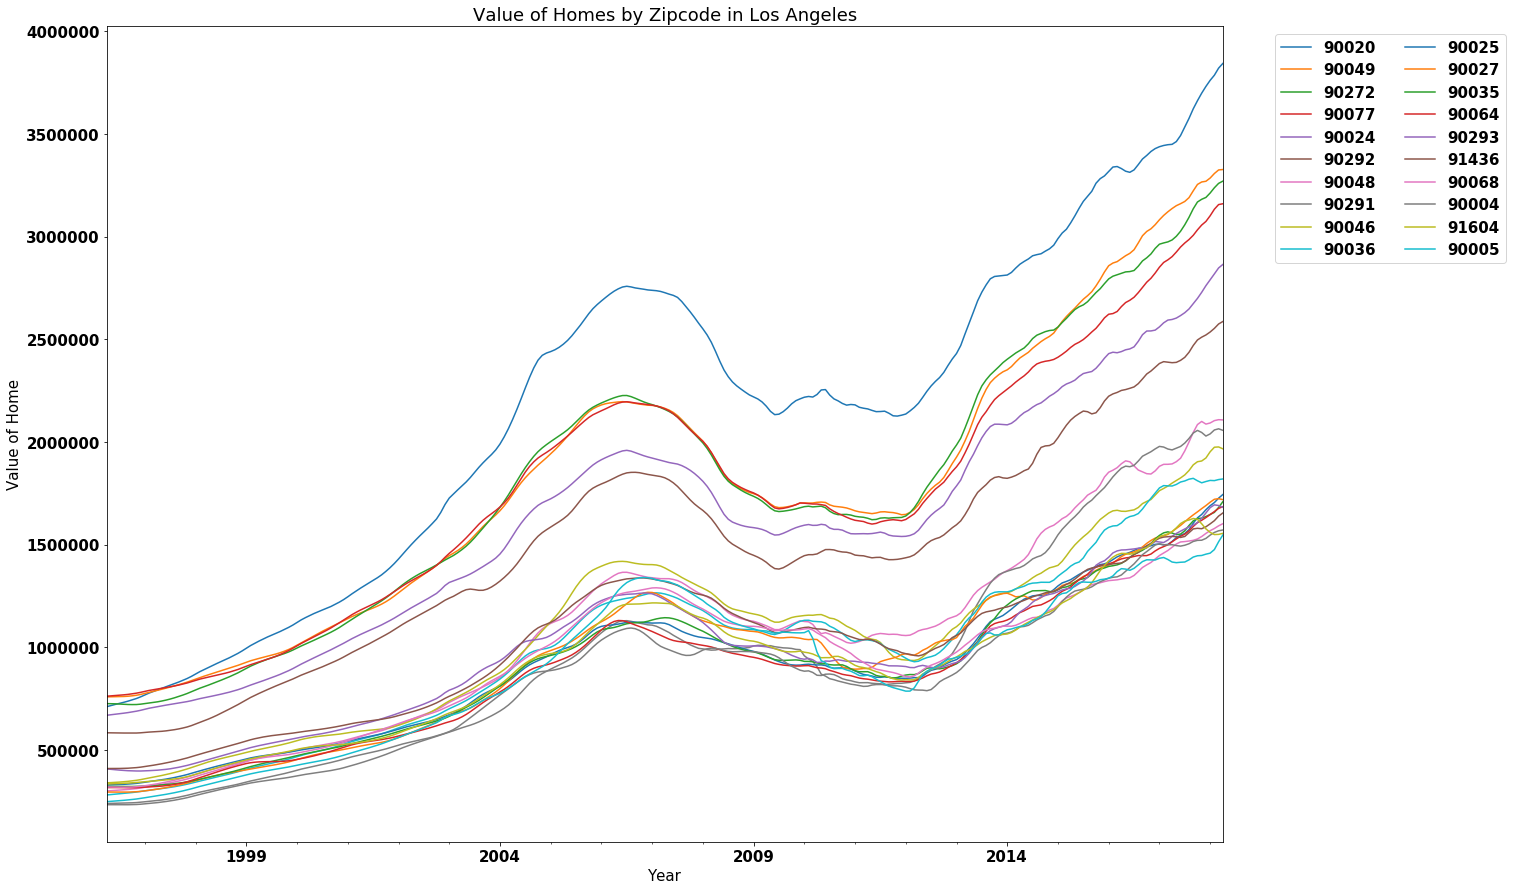

In [16]:
## graphing the value of homes in top 20 zipcodes

for zipcode in top_20['RegionName'].unique():
    temp_df = top_20[top_20['RegionName'] == zipcode].drop('RegionName', axis=1).set_index('time')
    temp_df['value'].plot(figsize=(20, 15), label=zipcode)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.ylabel('Value of Home')
plt.xlabel('Year')
plt.title('Value of Homes by Zipcode in Los Angeles')
plt.show()

We want to make decision based on post housing crash trends so we'll only be taking a look at data from 2010 onward.

In [17]:
## separate data to only include dates after 2010

LA = top_20[top_20['time'] > '2009-12']
LA.head()

,RegionName,time,value
3300,90020,2010-01-01,2217900.0
3301,90049,2010-01-01,1703200.0
3302,90272,2010-01-01,1685200.0
3303,90077,2010-01-01,1702000.0
3304,90024,2010-01-01,1594900.0


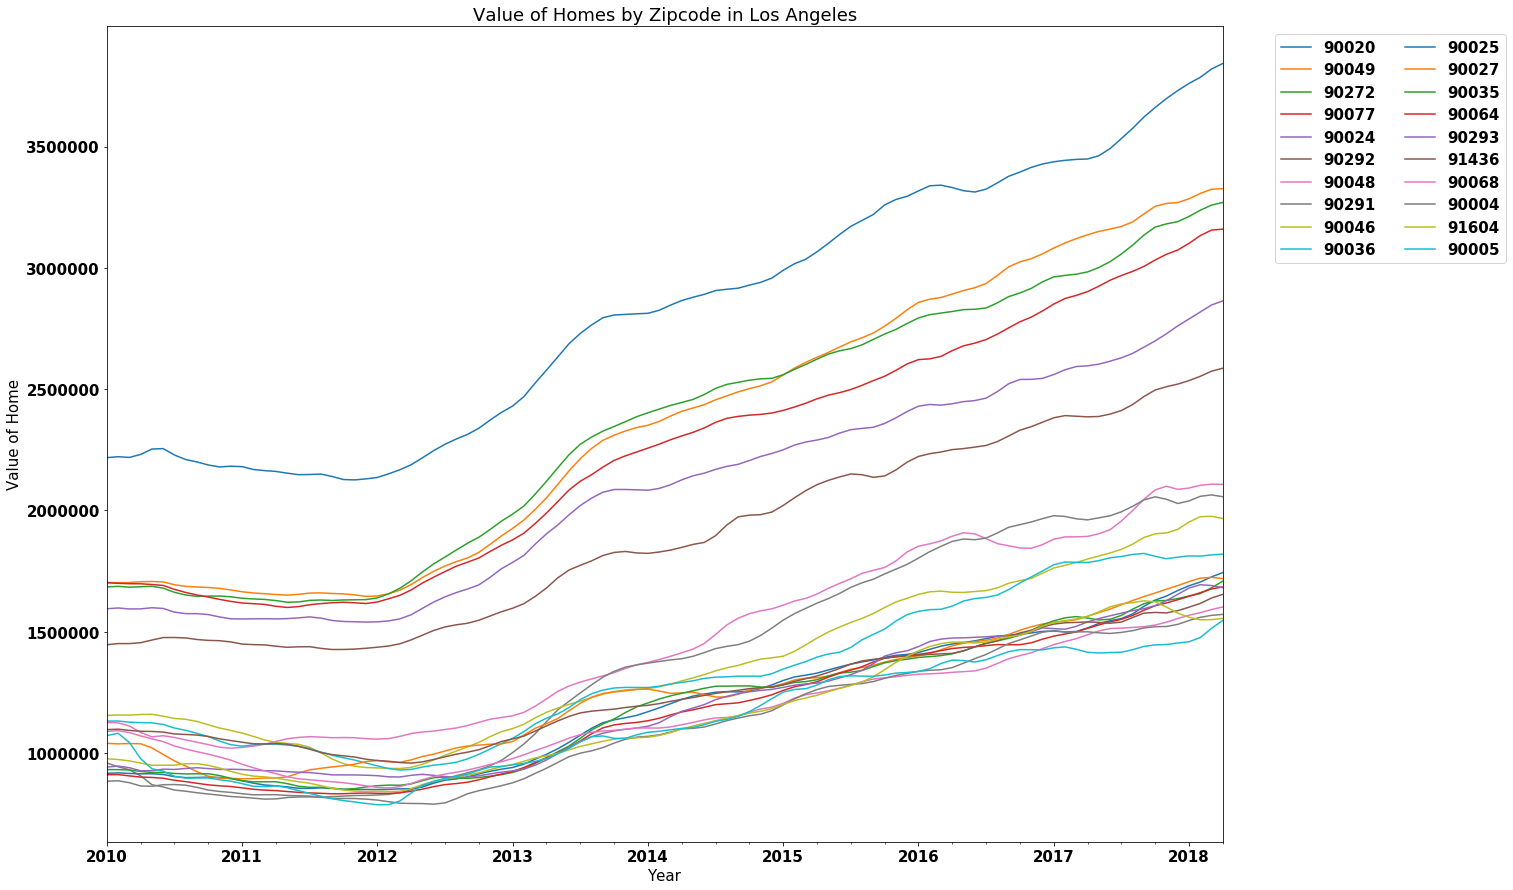

In [18]:
for zipcode in LA['RegionName'].unique():
    temp_df = LA[LA['RegionName'] == zipcode].drop('RegionName', axis=1).set_index('time')
    temp_df['value'].plot(figsize=(20, 15), label=zipcode)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.ylabel('Value of Home')
plt.xlabel('Year')
plt.title('Value of Homes by Zipcode in Los Angeles')
plt.show()

# Removing Trends

I'll be going through 2 zipcodes to see which method works best to make the data stationary. The zipcodes I'll be using are 90272 and 90025. When looking at the graph above, the zipcodes seem to be split between the top 6 zipcodes by values and the rest of the zipcodes. 90272 is part of the top 6 zipcodes by value while 90025 is part of the bottom 14 zipcodes.

In [19]:
## function to check for stationarity
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS['value']) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

Text(0, 0.5, 'Value in Dollars')

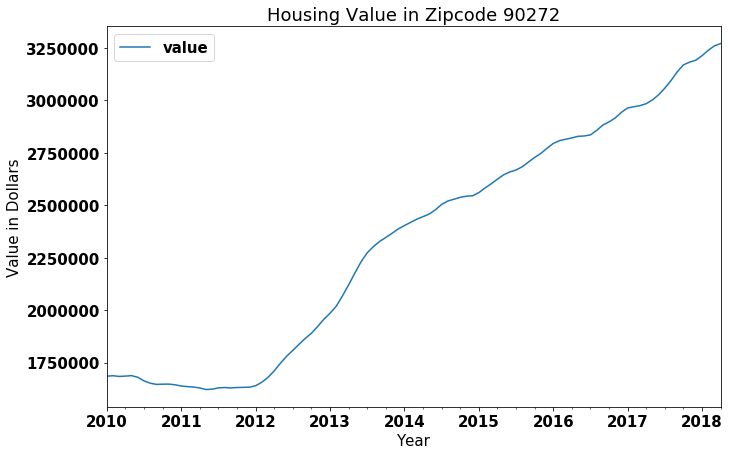

In [20]:
## splitting data into specific zipcodes

zip_90272 = LA[LA['RegionName'] == 90272].drop('RegionName', axis=1).set_index('time')
zip_90272.plot(figsize=(11, 7));
plt.title('Housing Value in Zipcode 90272')
plt.xlabel('Year')
plt.ylabel('Value in Dollars')

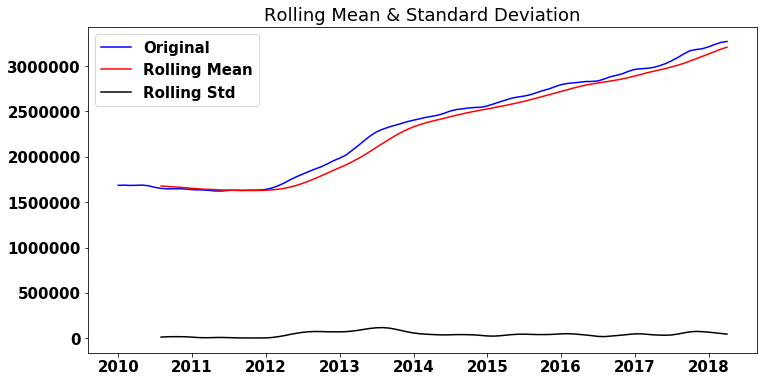

Results of Dickey-Fuller Test: 

Test Statistic                 -0.667612
p-value                         0.854961
#Lags Used                      9.000000
Number of Observations Used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64


In [21]:
stationarity_check(zip_90272)

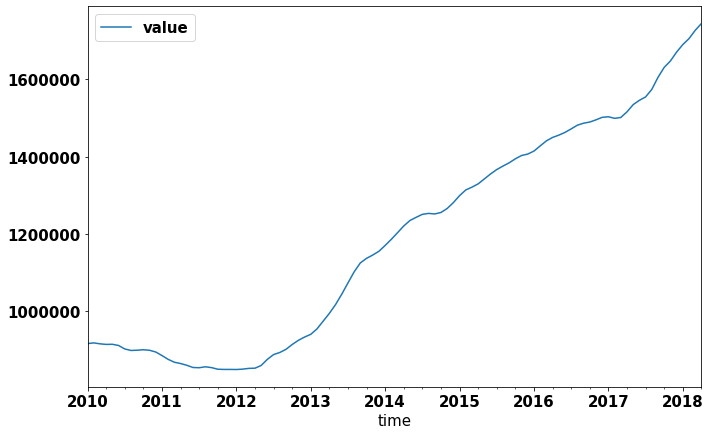

In [22]:
zip_90025 = LA[LA['RegionName'] == 90025].drop('RegionName', axis=1).set_index('time')
zip_90025.plot(figsize=(11,7));

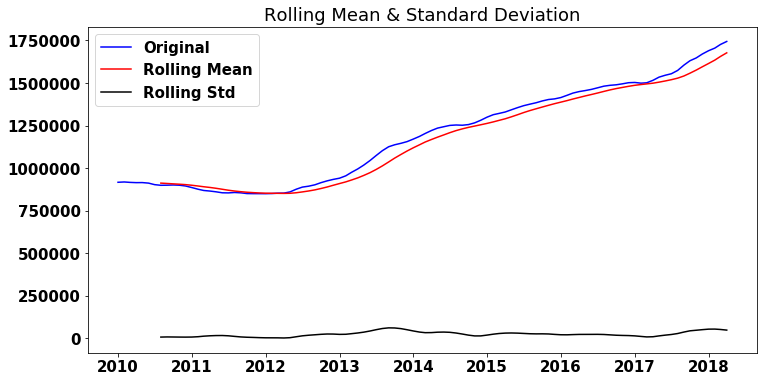

Results of Dickey-Fuller Test: 

Test Statistic                  0.134241
p-value                         0.968323
#Lags Used                      8.000000
Number of Observations Used    91.000000
Critical Value (1%)            -3.504343
Critical Value (5%)            -2.893866
Critical Value (10%)           -2.584015
dtype: float64


In [49]:
stationarity_check(zip_90025)

Just by taking a look at our two graphs, we can see there is a clear upward linear trend. The Dickey-Fuller test has a null hypothesis that the data is not stationary. With a p-value much greater than 0.05 for both datasets, we fail to reject the null hypothesis and conclude that our data is not stationary.

## Differencing

I'll be taking a look to see if our data will become stationary through differencing so that it can be used in ARIMA modeling.

In [166]:
diff_90272 = np.log(zip_90272).diff(periods=4)
diff_90272.dropna(inplace=True)

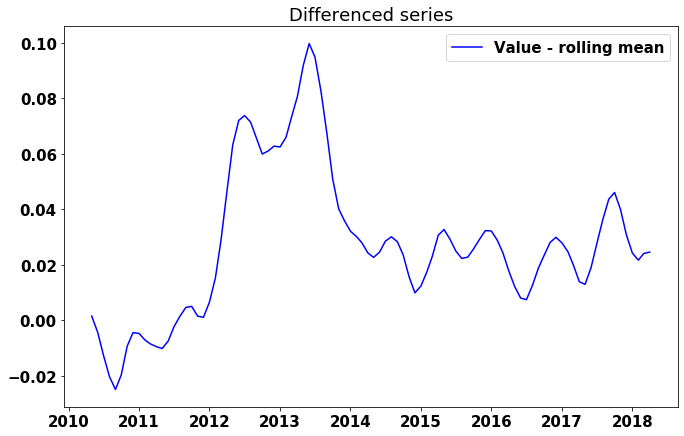

In [167]:
fig = plt.figure(figsize=(11,7))
plt.plot(diff_90272, color='blue',label='Value - rolling mean')
plt.legend(loc='best')
plt.title('Differenced series')
plt.show(block=False)

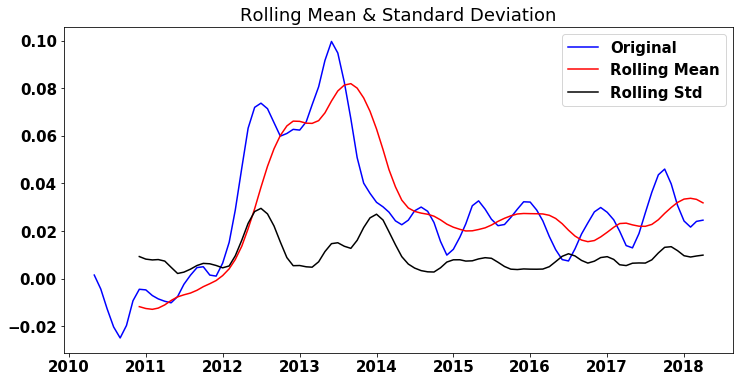

Results of Dickey-Fuller Test: 

Test Statistic                 -3.423992
p-value                         0.010168
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [168]:
stationarity_check(diff_90272)

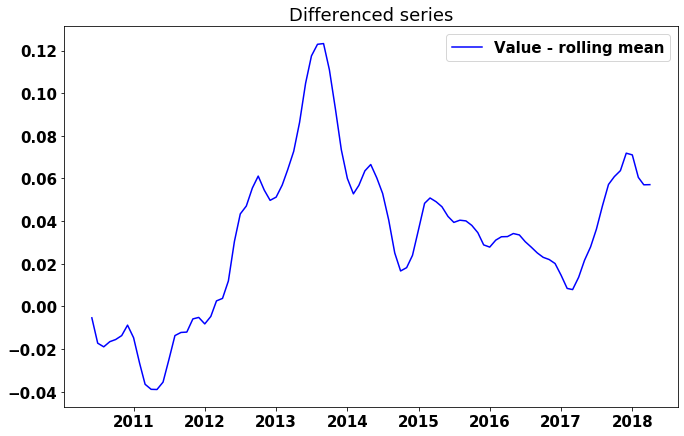

In [161]:
diff_90025 = np.log(zip_90025).diff(periods=5)
diff_90025.dropna(inplace=True)

fig = plt.figure(figsize=(11,7))
plt.plot(diff_90025, color='blue',label='Value - rolling mean')
plt.legend(loc='best')
plt.title('Differenced series')
plt.show(block=False)

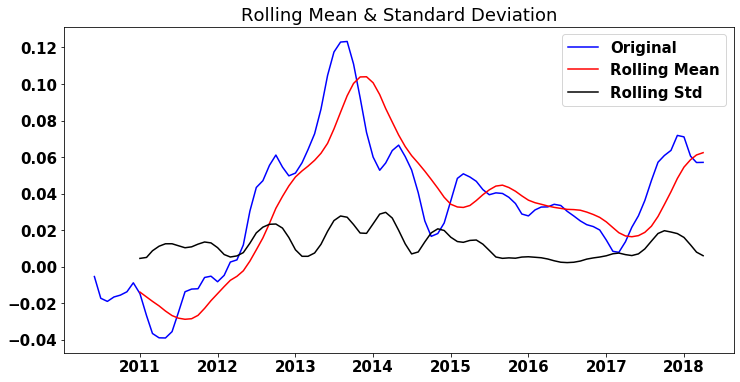

Results of Dickey-Fuller Test: 

Test Statistic                 -2.932425
p-value                         0.041705
#Lags Used                     11.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [162]:
stationarity_check(diff_90025)

I had to take the log transformation for zipcode 90025 to be able to make the data stationary using differencing. Because of this I will be using log transformed data before running it through the ARIMA model.

With p values lower than 0.05 for both zipcodes, we can reject the null hypothesis and conclude that our data is stationary.

## Decomposition

In [39]:
## define a function to decompose data to see trends, seasonality, and residuals

def decomposition(df):
    sd = seasonal_decompose(df)

    # Gather the trend, seasonality, and residuals 
    trend = sd.trend
    seasonal = sd.seasonal
    residual = sd.resid

    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(df, label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout()
    
    return residual.dropna()

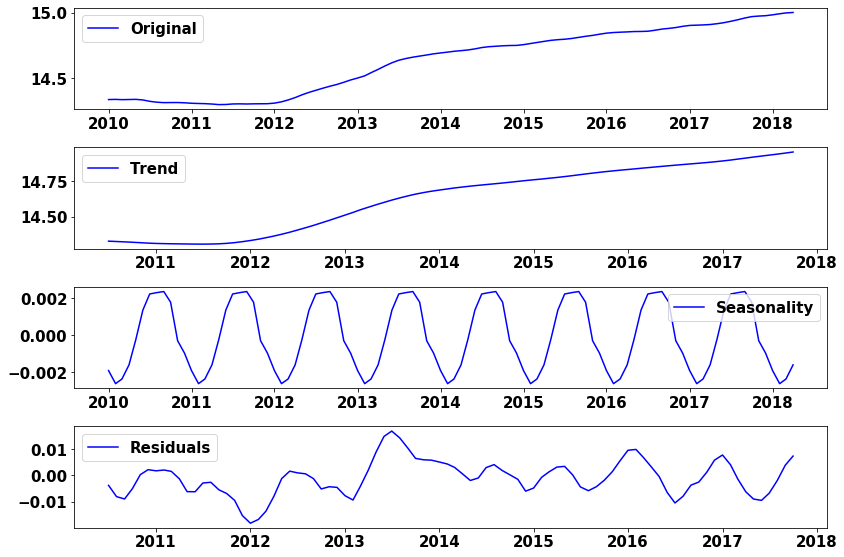

In [169]:
sd_90272 = decomposition(np.log(zip_90272))

Looks like there is an upward trend that stabilizes between 2014 and 2015. It looks like there is seasonality in the data looking at the seasonality graph but with the range of values being so low we can assume that there is no seasonality in our data. A quick glance at the graph of our original data confirms this because there does not seem to be any seasonality in the graph of our original data before decomposition.

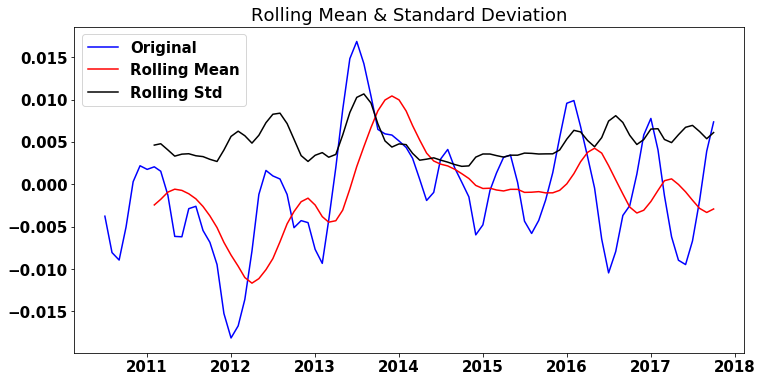

Results of Dickey-Fuller Test: 

Test Statistic                 -2.382952
p-value                         0.146606
#Lags Used                      6.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


In [170]:
# Check stationarity
stationarity_check(sd_90272)

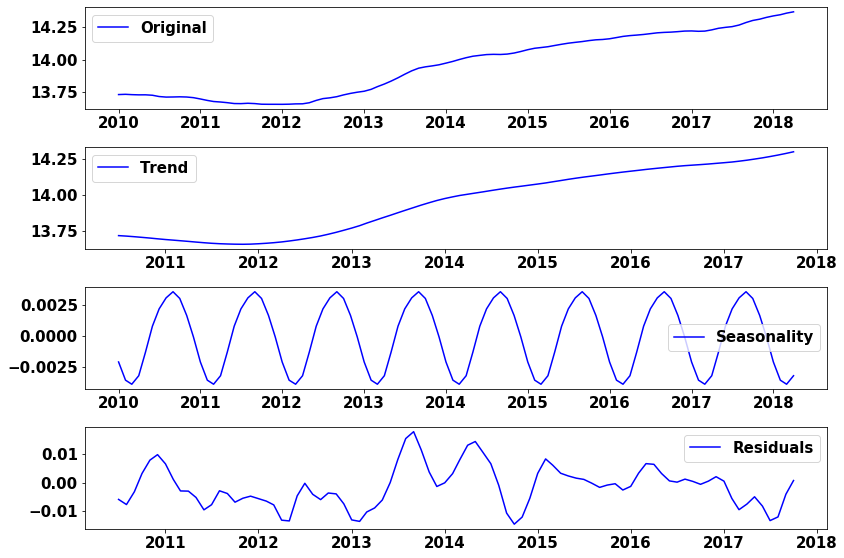

In [171]:
sd_90025 = decomposition(np.log(zip_90025))

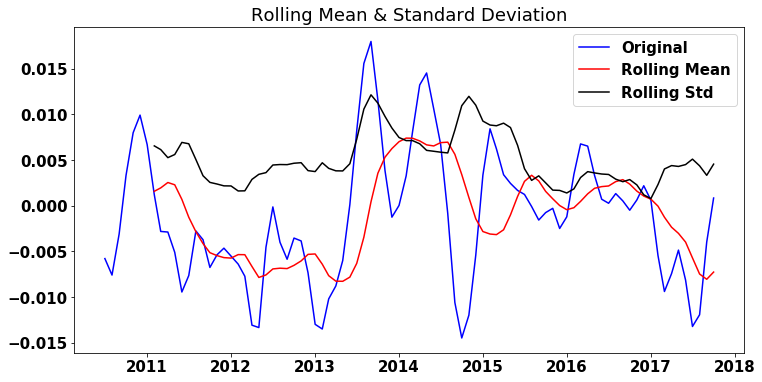

Results of Dickey-Fuller Test: 

Test Statistic                 -2.758424
p-value                         0.064462
#Lags Used                      4.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [172]:
stationarity_check(sd_90025)

Without differencing, the residuals in our log transformed time series data are not stationary.


# SARIMA Modeling

Lets fit a new SARIMAX model to our data. I'll begin by finding the best parameters to use for our model. To do this, I'll be using a grid search to find the optimal parameters for the model.

In [89]:
## generate all different combinations for p, q, and d. Using a range of 6 because the differencing periods required
## to make our data stationary for zipcode 90025 was 5

p = d = q = range(0, 6)
pdq = list(itertools.product(p, d, q))

In [90]:
## define a function that iterates over all pdq values and returns the combination that has the lowest AIC score

def get_optimal_pdq(df, pdq):
    results = []
    for comb in pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=comb,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            results.append([comb, output.aic])
            # print('ARIMA {} : AIC Calculated ={}'.format(comb, output.aic))
        except:
            continue
    
    return sorted(results, key=lambda x: x[-1])[0][0]

In [173]:
get_optimal_pdq(np.log(zip_90272), pdq)

(1, 1, 3)

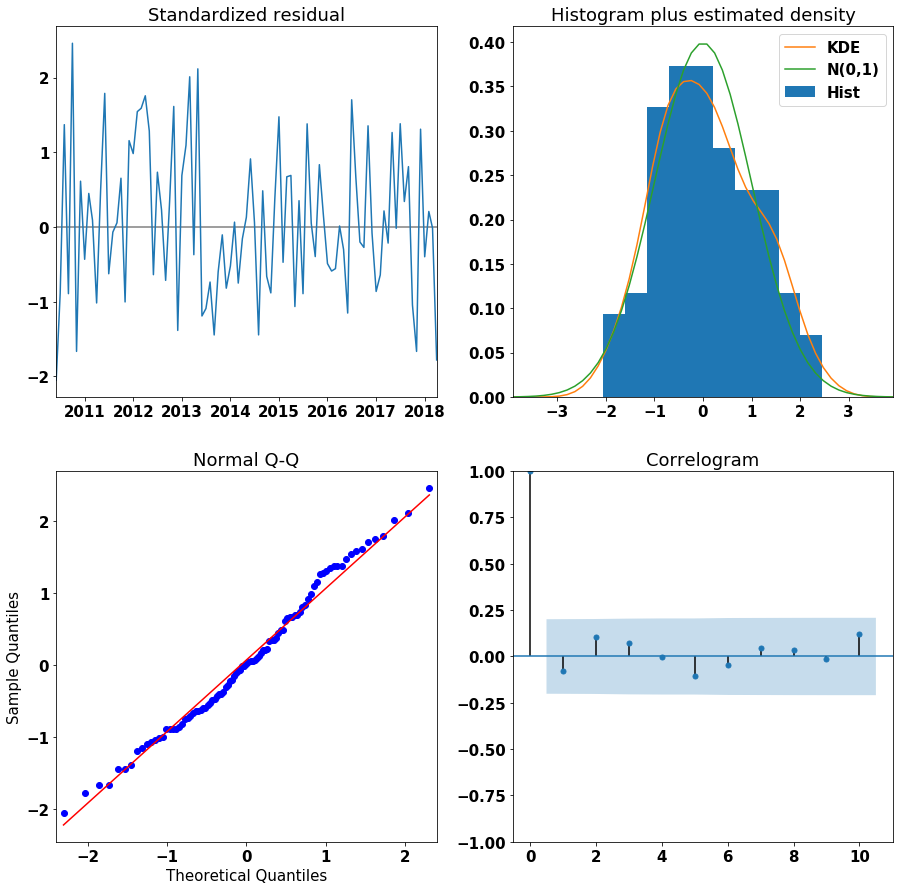

In [174]:
model_90272 = sm.tsa.statespace.SARIMAX(np.log(zip_90272),
                                        order=(1, 1, 3),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
output = model_90272.fit()
output.plot_diagnostics(figsize=(15, 15))
plt.show()

In the graph on the top left, there doesn't seem to be any seasonality in our data. Looking at the histogram and qq plots, we can see that our data follows the trend of the standard normal distribution showing a good indication that the residuals are normally distributed. These observations show that our model has no correlations and provides a satisfactory fit to forecast future values. 

Let's check the 90025 zip code to see if it also has normally distributed residuals and no correlation.

In [175]:
get_optimal_pdq(np.log(zip_90025), pdq)

(2, 1, 3)

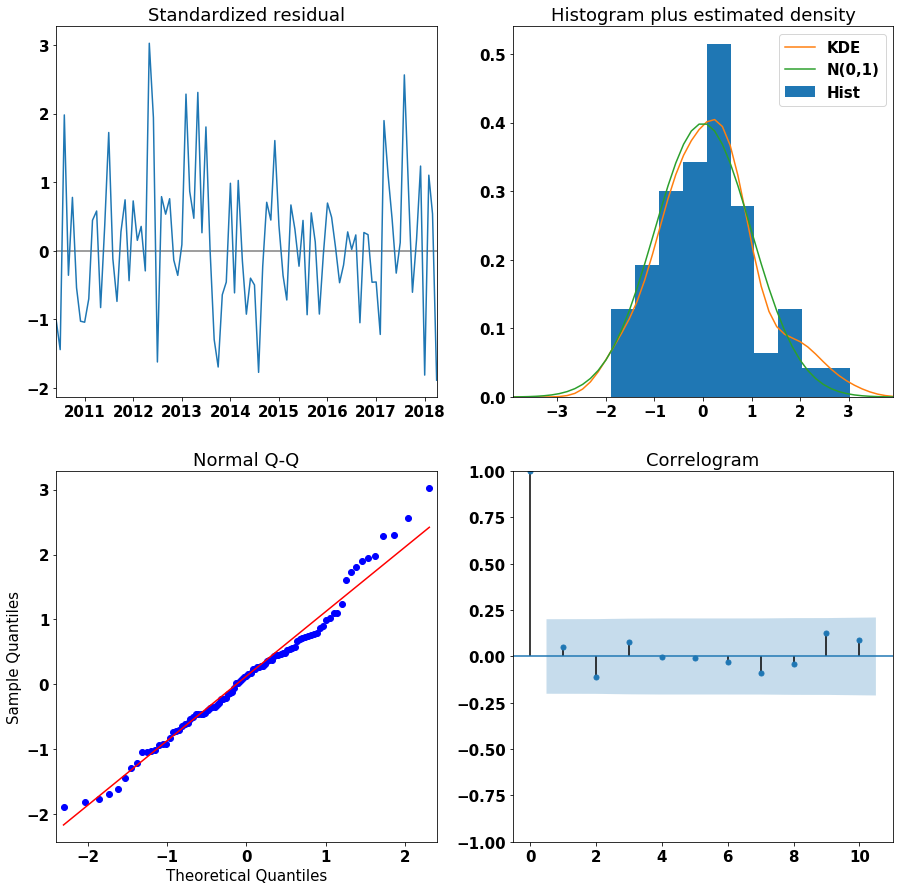

In [176]:
model_90025 = sm.tsa.statespace.SARIMAX(np.log(zip_90025),
                                        order=(2, 1, 3),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
output = model_90025.fit()
output.plot_diagnostics(figsize=(15, 15))
plt.show()

The residuals from 90025 also remain uncorrelated and normally distributed. Now let's forecast future values.

In [177]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_conf = pred.conf_int()

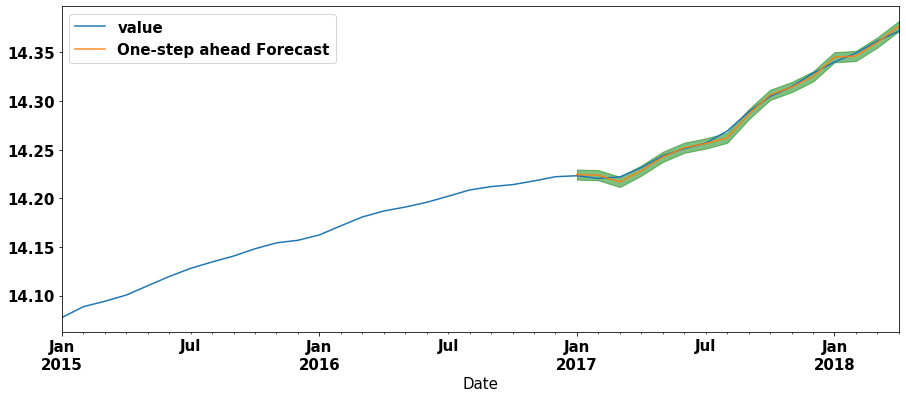

In [179]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = np.log(zip_90025)['2015':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
plt.legend()

plt.show()

In [181]:
forecast = pred.predicted_mean
real = np.log(zip_90025)['2017-01-01':]['value']

mse = ((forecast - real) ** 2).mean()
print(f'The MSE of our forecast is {round(mse, 2)}')

The MSE of our forecast is 0.0


# Step 6: Interpreting Results